<a href="https://colab.research.google.com/github/smontes-fing/UTE_PRESENTACION/blob/main/predecir_demanda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar dependencias



In [ ]:
# Instalacion de dependencias
!pip install icecream
!pip install pandas==2.2.2
!pip install tensorflow==2.12
!pip install pillow matplotlib
!pip install netCDF4
!pip install gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.3 MB/s eta 0:00:00



# Instalo dependencias
Instalo las dependencias con sus versiones con las que fueron testeados los scripts .py

In [ ]:
# !unzip UTE_presentacion.zip
# #remuevo los archivos que no son necesarios
# !rm -rf __MACOSX
# !rm UTE_presentacion.zip

%cd /content
!rm -rf UTE_PRESENTACION
!git clone https://github.com/smontes-fing/UTE_PRESENTACION.git

/content
Cloning into 'UTE_PRESENTACION'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 137 (delta 17), reused 39 (delta 8), pack-reused 83 (from 1)
Receiving objects: 100% (137/137), 82.44 MiB | 10.87 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Updating files: 100% (73/73), done.


In [ ]:
# Agregar el path /UTE_PRESENTACION al sys.path de python
import sys
import os

# Agregar el directorio al path
sys.path.append(os.path.abspath('UTE_PRESENTACION/'))

# Verificar que el directorio se haya agregado correctamente
print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/UTE_PRESENTACION']


In [ ]:
# Cambiar al directorio UTE_presentacion
os.chdir('UTE_PRESENTACION')

# Verificar que estamos en el directorio correcto
print(os.getcwd())  # Imprime el directorio actual

In [ ]:
# Verifico que estoy en el directorio correcto /content/UTE_PRESENTACION
!pwd

/content/UTE_PRESENTACION


# Predecir demanda

El objetivo es generar predicciones en base a un conjunto de años sintéticos de temperatura cargados desde un archivo. El pipeline del modelo de predicción y proyección y el flujo de los datos está representado en la siguiente figura.

![Pipeline completo del flujo de datos y el modelo](Imagenes_pipeline/DiagramaFlujo-v5.png)

En esta sección vamos a cargar los datos de temperatura sintéticos ya generados y predicir la demanda con el modelo normalizado.
Con el modelo econométrico se utiliza para proyectar la energía a consumir en el año a estudio y escalar el resultado de la predicción.

![Modelo de predicción de demanda](Imagenes_pipeline/sintetizador_demanda.png)




In [ ]:
import pandas as pd
import argparse
from PIL import Image
import os
import numpy as np
from icecream import ic
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from pickle import load
import matplotlib.pyplot as plt
from funciones.utils_transform import (
    transform_norm,
)
from generar_estadisticas import plot_datos_semana
from funciones.utils import def_rango_fecha
from predecir_demanda import (
    load_data,
    fijar_energia_anual,
    load_model_and_scaler,
    generar_predicciones,
)

print(f"TensorFlow version = {tf.__version__}")
print(f"TensorFlow version = {pd.__version__}")
print(f"TensorFlow version = {np.__version__}")


TensorFlow version = 2.12.0
TensorFlow version = 2.2.2
TensorFlow version = 1.23.5


In [ ]:
# Se setean los parámetros de entrada

ano_to_predict  = 2030
data_input_path   = 'datos/temp_sintetico_2.csv'
model_type   = 'norm'
output_path  = 'salida/demanda_sim/resultados.csv'
model_path   = 'modelos/UTE_ANN_test'
scaler_path  = 'modelos/UTE_ANN_test/scaler_UTE_ANN_test.pkl'

In [ ]:
# Proyección de Energía Anual
e_obj, e_base   =  fijar_energia_anual(ano_to_predict)
print(f"Energía consumida en 2021: {e_base}")
print(f"Energía consumida en {ano_to_predict}: {e_obj}")


Energía consumida en 2021: 10671561
Energía consumida en 2030: 12653360


In [ ]:
data_temp = pd.DataFrame()
print("Cargando datos de temperatura")
data_temp = load_data(data_input_path)

Cargando datos de temperatura


In [ ]:
print(f"Columnas del DataFrame de Temperatura: {data_temp.columns}")
data_temp.iloc[1000:1000+5].head()

Columnas del DataFrame de Temperatura: Index(['time', 'DiaSemana', 'Ano', 'Mes', 'Dia', 'Hora', 'Temp', 'semana',
       'sintetic'],
      dtype='object')


,time,DiaSemana,Ano,Mes,Dia,Hora,Temp,semana,sintetic
1000,2014-02-11 16:00:00,1,2014,2,11,16,28.815286,6,1
1001,2014-02-11 17:00:00,1,2014,2,11,17,26.306367,6,1
1002,2014-02-11 18:00:00,1,2014,2,11,18,24.043808,6,1
1003,2014-02-11 19:00:00,1,2014,2,11,19,23.388261,6,1
1004,2014-02-11 20:00:00,1,2014,2,11,20,22.938723,6,1


Datos de entrada

[Estructura de los datos de entrada al modelo](Imagenes_pipeline/data_input.png)

# Cargo el modelo y sus datos de entrenamiento

### Cargo el modelo y muesto los resultados

In [ ]:
model, scaler   = load_model_and_scaler(model_path, scaler_path)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
ic| type(model): <class 'keras.engine.sequential.Sequential'>
ic| type(scaler): <class 'sklearn.preprocessing._data.MinMaxScaler'>


In [ ]:
print(f"Modelo cargado: {model.name}")
model.summary()

Modelo cargado: Modelo_ANN
Model: "Modelo_ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              6144      
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             

### Muestro el proceso de entrenamiento LOSS Vs ACC

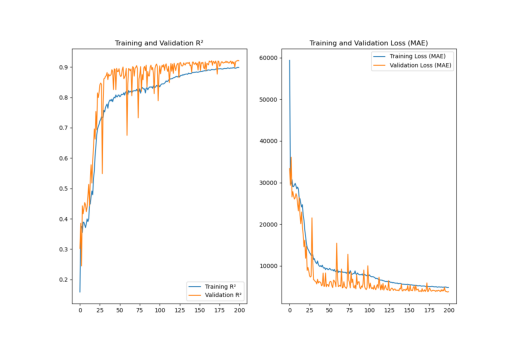

In [ ]:
# Cargar la imagen usando PIL
image_r2 = Image.open('modelos/UTE_ANN_test/entrenamiento/r_squared_and_loss.png')

# Mostrar la imagen usando matplotlib
plt.imshow(image_r2)
plt.axis('off')  # Opcional, oculta los ejes
plt.show()


### Comparo dos métricas de Loss: MAPE y MAE

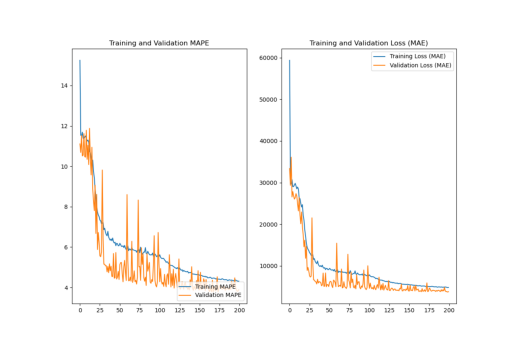

In [ ]:
# Cargar la imagen usando PIL
image = Image.open('modelos/UTE_ANN_test/entrenamiento/mape_and_loss.png')

# Mostrar la imagen usando matplotlib
plt.imshow(image)
plt.axis('off')  # Opcional, oculta los ejes
plt.show()


### Genero las predicciones

Genero las predicciones de los años cargados

In [ ]:
print("Generando predicciones")
df_pred = pd.DataFrame()
df_pred = generar_predicciones(
                    data_temp,
                    e_obj,
                    e_base,
                    model_type,
                    model,
                    scaler,
                    output_path
                    )

ic| data_raw.head(3):    DiaSemana  Mes  Dia  Hora       Temp
                      0          6    1    1     0  26.416805
                      1          6    1    1     1  26.133631
                      2          6

Generando predicciones


    1    1     2  24.951380
ic| "Datos de Temperatura": 'Datos de Temperatura'
    data.columns: Index(['DiaSemana', 'Mes', 'Dia', 'Hora', 'Temp'], dtype='object')
ic| columnas_fature: ['DiaSemana', 'Mes', 'Dia', 'Hora', 'Temp']
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


548/548 [==============================] - 15s 26ms/step


ic| data_raw.head(3):    DiaSemana  Mes  Dia  Hora       Temp
                      0          6    1    1     0  26.416805
                      1          6    1    1     1  26.133631
                      2          6    1    1     2  24.951380
ic| "Datos de Temperatura": 'Datos de Temperatura'
    data.columns: Index(['DiaSemana', 'Mes', 'Dia', 'Hora', 'Temp'], dtype='object')
ic| columnas_fature: ['DiaSemana', 'Mes', 'Dia', 'Hora', 'Temp']
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


548/548 [==============================] - 8s 15ms/step


In [ ]:
# Muestro las características de las predicciones
print(f"Dimensiones del dataframe de predicciones: {df_pred.shape}")
print(df_pred.head(5))
df_pred.shape

Dimensiones del dataframe de predicciones: (17520, 2)
         Ano_0        Ano_1
0  1444.723022  1444.723022
1  1365.914551  1365.914551
2  1330.782349  1330.782349
3  1314.308105  1314.308105
4  1302.347290  1302.347290


(17520, 2)

In [ ]:
# path donde se guardan los resultados
print(f"Path de resultados: {output_path}")


Path de resultados: salida/demanda_sim/resultados.csv


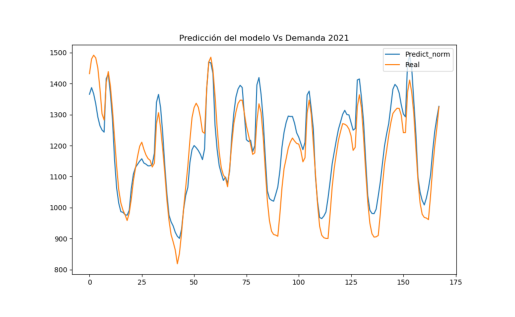

In [ ]:
# Cargar la imagen de validación al entrenar el modelo
image = Image.open('modelos/UTE_ANN_test/entrenamiento/comparacion_predicciones.png')
plt.imshow(image)
plt.axis('off')  # Opcional, oculta los ejes
plt.show()


Imprimo algunos resultados

In [ ]:
df_pred_return = df_pred.copy()
# Muestro una sema especifica del anio con la demanda driver y la proyectada
# Preprocess de los datos de calendario
date_range = def_rango_fecha(str(ano_to_predict))

df_pred.index = date_range


start_date = f'{ano_to_predict}-06-15'
end_date = pd.Timestamp(start_date) + pd.DateOffset(days=7)
week_data = df_pred.loc[start_date:end_date]
#plot_datos_semana(week_data, start_date, end_date)
plot_datos_semana(week_data,
                  start_date,
                  end_date,
                  ano_to_predict,
                  curva = "",
                  path = "output/predicciones_semana.png")

ValueError: Length mismatch: Expected axis has 17520 elements, new values have 8760 elements

# Predicciones 2021 para testear modelo

Muestro las predicciones para una semana en particular.

In [ ]:
# genero las predicciones
df_pred21 = df.DataFrame()
df_pred21 =